In [11]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class SpeedControlEnv(gym.Env):
    """
    Простая среда управления скоростью.
    Цель агента - поддерживать скорость объекта близкой к target_speed.
    Действие: ускорение в диапазоне [-1, 1].
    Наблюдение: текущая скорость (скаляр).
    """

    metadata = {'render_modes': ['human']}

    def __init__(self, render_mode=None):
        super().__init__()
        self.max_speed = 10.0
        self.min_speed = 0.0
        self.max_acceleration = 1.0
        self.dt = 0.1  # шаг времени
        self.target_speed = 5.0  # целевая скорость

        # Действие - ускорение в [-1, 1]
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        # Наблюдение - текущая скорость в [min_speed, max_speed]
        self.observation_space = spaces.Box(low=np.array([self.min_speed], dtype=np.float32),
                                            high=np.array([self.max_speed], dtype=np.float32),
                                            dtype=np.float32)

        self.state = None
        self.time = 0.0
        self.max_time = 20.0  # максимальная длительность эпизода

        self.render_mode = render_mode

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0.0], dtype=np.float32)  # стартовая скорость 0
        self.time = 0.0
        if self.render_mode == 'human':
            print(f"Episode reset. Start speed: {self.state[0]:.2f}")
        return self.state, {}

    def step(self, action):
        # Ограничиваем действие
        accel = np.clip(action[0], -1, 1) * self.max_acceleration

        # Обновляем скорость с учетом ускорения и dt
        speed = self.state[0] + accel * self.dt
        speed = np.clip(speed, self.min_speed, self.max_speed)

        self.state = np.array([speed], dtype=np.float32)
        self.time += self.dt

        # Вычисляем ошибку скорости
        error = speed - self.target_speed

        # Награда - отрицательный квадрат ошибки (чем ближе к цели, тем лучше)
        reward = - (error ** 2)

        # Эпизод заканчивается, если время вышло
        done = self.time >= self.max_time

        info = {
            "speed": speed,
            "target_speed": self.target_speed,
            "error": error
        }

        if self.render_mode == 'human':
            print(f"Time: {self.time:.1f}s | Speed: {speed:.2f} | Error: {error:.2f} | Reward: {reward:.3f}")

        return self.state, float(reward), done, False, info

    def render(self, mode='human'):
        if mode == 'human':
            print(f"Current speed: {self.state[0]:.2f}")

    def close(self):
        pass


Episode reset. Start speed: 0.00
Episode reset. Start speed: 0.00
Time: 0.1s | Speed: 0.03 | Error: -4.97 | Reward: -24.665
Episode reset. Start speed: 0.00
Time: 0.1s | Speed: 0.09 | Error: -4.91 | Reward: -24.153
Time: 0.2s | Speed: 0.01 | Error: -4.99 | Reward: -24.924
Time: 0.3s | Speed: 0.00 | Error: -5.00 | Reward: -25.000
Time: 0.4s | Speed: 0.10 | Error: -4.90 | Reward: -24.047
Time: 0.5s | Speed: 0.13 | Error: -4.87 | Reward: -23.672
Time: 0.6s | Speed: 0.05 | Error: -4.95 | Reward: -24.529
Time: 0.7s | Speed: 0.00 | Error: -5.00 | Reward: -25.000
Time: 0.8s | Speed: 0.01 | Error: -4.99 | Reward: -24.874
Time: 0.9s | Speed: 0.06 | Error: -4.94 | Reward: -24.404
Time: 1.0s | Speed: 0.13 | Error: -4.87 | Reward: -23.736
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode reset. Start speed: 0.00
Time: 0.1s | Speed: 0.00 | Error: -5.00 | Reward: -25.000
T

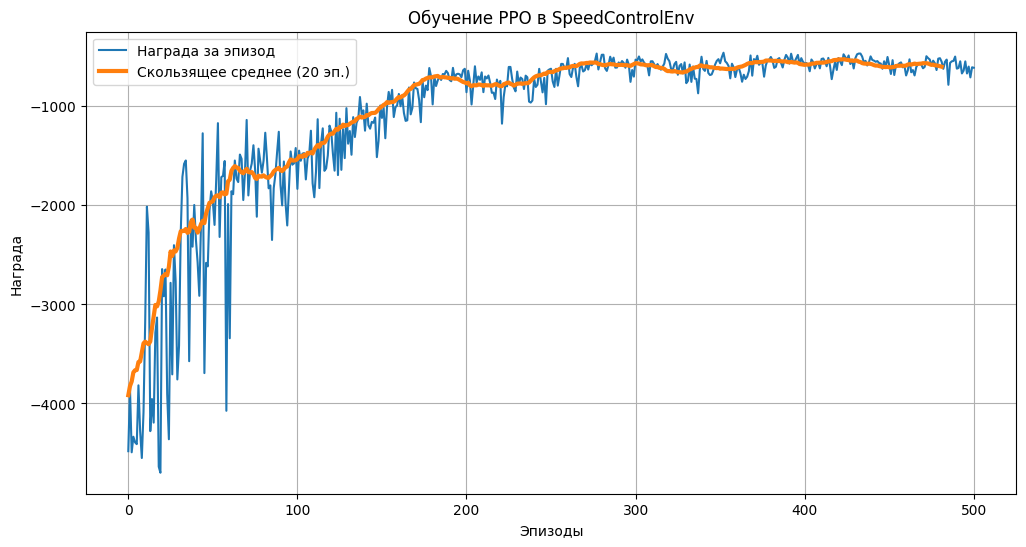

In [12]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt

# Создаем среду
env = SpeedControlEnv(render_mode="human")
check_env(env)

config = {
    "policy": "MlpPolicy",
    "learning_rate": 3e-4,
    "n_steps": 2048,          # Число шагов перед обновлением
    "batch_size": 64,         # Размер батча для обучения
    "n_epochs": 10,           # Число эпох на один набор данных
    "gamma": 0.99,            # Коэффициент дисконтирования
    "gae_lambda": 0.95,       # Параметр для GAE
    "ent_coef": 0.01,         # Коэффициент энтропии
    "verbose": 1              # Вывод логов
}

# Создаем модель PPO
model = PPO(
    policy=config["policy"],
    env=env,
    learning_rate=config["learning_rate"],
    n_steps=config["n_steps"],
    batch_size=config["batch_size"],
    n_epochs=config["n_epochs"],
    gamma=config["gamma"],
    gae_lambda=config["gae_lambda"],
    ent_coef=config["ent_coef"],
    verbose=config["verbose"]
)

# Параметры обучения
total_timesteps = 100_000
log_interval = 100  # через сколько итераций выводить статистику

# Для сбора статистики
episode_rewards = []
episode_lengths = []

# Коллбек для сбора статистики
class RewardLoggerCallback(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.episode_rewards = []
        self.episode_reward = 0
        self.episode_lengths = []
        self.episode_length = 0

    def reset(self, **kwargs):
        if self.episode_length > 0:
            self.episode_rewards.append(self.episode_reward)
            self.episode_lengths.append(self.episode_length)
        self.episode_reward = 0
        self.episode_length = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_reward += reward
        self.episode_length += 1
        if done or truncated:
            self.episode_rewards.append(self.episode_reward)
            self.episode_lengths.append(self.episode_length)
            self.episode_reward = 0
            self.episode_length = 0
        return obs, reward, done, truncated, info

# Оборачиваем среду для логирования
log_env = RewardLoggerCallback(env)


# Обучение с логированием
model.set_env(log_env)
model.learn(total_timesteps=total_timesteps, log_interval=log_interval, progress_bar=True)

# После обучения выводим статистику
rewards = log_env.episode_rewards

# Скользящее среднее для сглаживания графика
def moving_average(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

avg_rewards = moving_average(rewards)

print(f"Средняя награда за последние {len(rewards)} эпизодов: {np.mean(rewards):.3f}")
print(f"Максимальная награда: {np.max(rewards):.3f}")
print(f"Минимальная награда: {np.min(rewards):.3f}")

# Строим график
plt.figure(figsize=(12,6))
plt.plot(rewards, label='Награда за эпизод')
plt.plot(range(len(avg_rewards)), avg_rewards, label='Скользящее среднее (20 эп.)', linewidth=3)
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.title('Обучение PPO в SpeedControlEnv')
plt.legend()
plt.grid()
plt.show()